In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm, trange
from matplotlib import pyplot as plt 
import networkx as nx
import numpy as np
import random

%matplotlib inline

In [40]:
data_csv = pd.read_csv("data/raw/CR_graph_rel.csv")

In [41]:
data_csv

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_0,node_5,мордвины,мордвины,29.81720,4
1,node_0,node_10,мордвины,мордвины,11.63220,1
2,node_0,node_11,мордвины,мордвины,23.90440,2
3,node_0,node_18,мордвины,мордвины,11.25290,1
4,node_0,node_20,мордвины,мордвины,8.88252,1
...,...,...,...,...,...,...
67498,node_3741,node_3752,белорусы,белорусы,9.51327,1
67499,node_3745,node_3755,белорусы,белорусы,9.23221,1
67500,node_3749,node_3764,белорусы,белорусы,10.63310,1
67501,node_3754,node_3755,украинцы,белорусы,8.04722,1


In [25]:
clients_ethnicites = {}

for index, row in tqdm(data_csv.iterrows()):
    node1 = row["node_id1"]
    node2 = row["node_id2"]
    label1 = row["label_id1"]
    label2 = row["label_id2"]
    ibd_sum = row["ibd_sum"]

    id1 = int(node1[5:])
    id2 = int(node2[5:])

    clients_ethnicites[id1] = label1
    clients_ethnicites[id2] = label2

clients_ethnicites = dict(sorted(clients_ethnicites.items()))

67503it [00:03, 17066.77it/s]


In [26]:
counts = {
            'мордвины': 0,
            'белорусы': 0,
            'украинцы': 0,
            'южные-русские': 0,
            'северные-русские': 0,
        }

for id, ethnicity in clients_ethnicites.items():
    counts[ethnicity] += 1

In [27]:
counts

{'мордвины': 70,
 'белорусы': 463,
 'украинцы': 426,
 'южные-русские': 2177,
 'северные-русские': 631}

In [29]:
random.seed(42)

clients_ethnicites_train = {}
clients_ethnicites_test = {}

for id, ethnicity in clients_ethnicites.items():
    
    if random.random() < 0.7:
        clients_ethnicites_train[id] = ethnicity
    else:
        clients_ethnicites_test[id] = ethnicity

test_keys = set(clients_ethnicites_test.keys())

In [30]:
train_counts = {
            'мордвины': 0,
            'белорусы': 0,
            'украинцы': 0,
            'южные-русские': 0,
            'северные-русские': 0,
        }

test_counts = {
            'мордвины': 0,
            'белорусы': 0,
            'украинцы': 0,
            'южные-русские': 0,
            'северные-русские': 0,
        }

for id, ethnicity in clients_ethnicites_train.items():
    train_counts[ethnicity] += 1

for id, ethnicity in clients_ethnicites_test.items():
    test_counts[ethnicity] += 1

In [31]:
train_counts

{'мордвины': 51,
 'белорусы': 327,
 'украинцы': 288,
 'южные-русские': 1495,
 'северные-русские': 464}

In [32]:
test_counts

{'мордвины': 19,
 'белорусы': 136,
 'украинцы': 138,
 'южные-русские': 682,
 'северные-русские': 167}

In [33]:
old_new_indices = {}
count = 0

for id, ethnicity in clients_ethnicites_train.items():
    old_new_indices[id] = count 
    count += 1

In [48]:
new_dataframe = []

for index, row in tqdm(data_csv.iterrows()):
    node1 = row["node_id1"]
    node2 = row["node_id2"]
    label1 = row["label_id1"]
    label2 = row["label_id2"]
    ibd_sum = row["ibd_sum"]

    id1 = int(node1[5:])
    id2 = int(node2[5:])
    
    if id1 in test_keys or id2 in test_keys:
        continue
    else:
        new_dataframe.append(["node_" + str(old_new_indices[id1]), "node_" + str(old_new_indices[id2]),
                                                                                 label1, label2, ibd_sum])
    
    
    

new_dataframe = pd.DataFrame(new_dataframe,
                             columns=["node_id1", "node_id2", "label_id1", "label_id2", "ibd_sum"])

new_dataframe.to_csv("train_data/raw/CR_graph_rel.csv")

67503it [00:03, 16932.55it/s]


# Подготовка тестовых данных

In [110]:
neighbors_test = {}

for client_id_test in clients_ethnicites_test:
    neighbors_test[client_id_test] = {"label": None,
                                      "neighbors_nodes": [],
                                      "neighbors_edge_weights": []}

oho = {
        'мордвины': torch.tensor([1, 0, 0, 0, 0], dtype=torch.float),
        'белорусы': torch.tensor([0, 1, 0, 0, 0], dtype=torch.float),
        'украинцы': torch.tensor([0, 0, 1, 0, 0], dtype=torch.float),
        'южные-русские': torch.tensor([0, 0, 0, 1, 0], dtype=torch.float),
        'северные-русские': torch.tensor([0, 0, 0, 0, 1], dtype=torch.float)
        }

d = {
        'мордвины': torch.tensor(0, dtype=torch.long),
        'белорусы': torch.tensor(1, dtype=torch.long),
        'украинцы': torch.tensor(2, dtype=torch.long),
        'южные-русские': torch.tensor(3, dtype=torch.long),
        'северные-русские': torch.tensor(4, dtype=torch.long)
        }

dd = {
        0: 'мордвины',
        1: 'белорусы',
        2: 'украинцы',
        3: 'южные-русские',
        4: 'северные-русские'
        }

for index, row in tqdm(data_csv.iterrows()):
    node1 = row["node_id1"]
    node2 = row["node_id2"]
    label1 = row["label_id1"]
    label2 = row["label_id2"]
    ibd_sum = row["ibd_sum"]

    id1 = int(node1[5:])
    id2 = int(node2[5:])
    
    if id1 in test_keys and id2 in test_keys:
        continue
    elif id1 in test_keys:
        neighbors_test[id1]["label"] = d[label1].item()
        neighbors_test[id1]["neighbors_nodes"].append(d[label2].item())
        neighbors_test[id1]["neighbors_edge_weights"].append(ibd_sum)
    elif id2 in test_keys:
        neighbors_test[id2]["label"] = d[label2].item()
        neighbors_test[id2]["neighbors_nodes"].append(d[label1].item())
        neighbors_test[id2]["neighbors_edge_weights"].append(ibd_sum)

67503it [00:03, 17202.29it/s]


In [52]:
len(neighbors_test)

1142

# Model inference

In [90]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(5, 10, 
                             add_self_loops=False,
                             normalize=False)
        self.fc1 = Linear(10, 10)
        self.fc2 = Linear(10, 5)

    def forward(self, x, edge_index, edge_weight):
        h = self.conv1(x, edge_index, edge_weight)
        h = h.relu()
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        return h

model = torch.load("model.pt").eval().state_dict()

In [96]:
ibd

[tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 1.]),
 tensor([0., 0., 0., 0., 1.]),
 tensor([0., 0., 0., 1., 0.])]

In [129]:
preds = []
true_s = []
faults = 0

incorrect_clients = {}

for client_test in neighbors_test:
    
    pred = torch.zeros(10)
    
    for ibd, neighbor_node in zip(neighbors_test[client_test]["neighbors_edge_weights"], neighbors_test[client_test]["neighbors_nodes"]):
        neighbor_node_attr = oho[dd[neighbor_node]]
        pred += ibd * torch.matmul(model['conv1.lin.weight'], neighbor_node_attr) + model['conv1.bias']
    
    pred = pred.relu()
    pred = torch.matmul(model['fc1.weight'], pred) + model['fc1.bias']
    pred = pred.relu()
    pred = torch.matmul(model['fc2.weight'], pred) + model['fc2.bias']
    
    pred = pred.argmax()
    
    preds.append(pred.item())
    true_s.append(neighbors_test[client_test]["label"])
    
    if pred.item() != neighbors_test[client_test]["label"]:
        faults += 1 
        incorrect_clients[client_test] = neighbors_test[client_test]
        incorrect_clients[client_test]["pred"] = pred.item()

In [130]:
oho

{'мордвины': tensor([1., 0., 0., 0., 0.]),
 'белорусы': tensor([0., 1., 0., 0., 0.]),
 'украинцы': tensor([0., 0., 1., 0., 0.]),
 'южные-русские': tensor([0., 0., 0., 1., 0.]),
 'северные-русские': tensor([0., 0., 0., 0., 1.])}

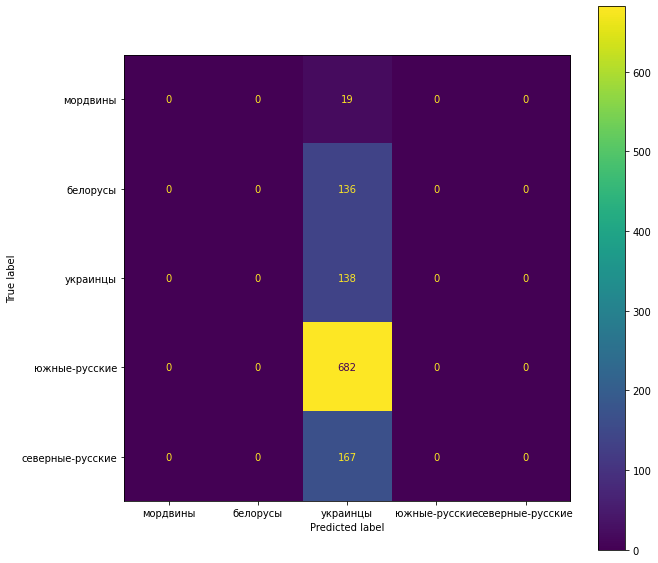

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sub_etnos = ['мордвины', 'белорусы', 'украинцы', 'южные-русские', 'северные-русские']

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(true_s, preds, display_labels=sub_etnos, ax=ax)

In [132]:
faults / len(clients_ethnicites_test)

0.8791593695271454

In [115]:
incorrect_clients

{18: {'label': 0,
  'neighbors_nodes': [0, 0, 4, 3, 3, 3, 3],
  'neighbors_edge_weights': [11.2529,
   9.40894,
   20.3839,
   8.62886,
   8.40928,
   12.3394,
   9.92114],
  'pred': 4},
 33: {'label': 1,
  'neighbors_nodes': [3, 3, 4, 1],
  'neighbors_edge_weights': [8.39006, 8.0234, 8.23367, 12.0552],
  'pred': 2},
 36: {'label': 1,
  'neighbors_nodes': [1, 1, 1, 2, 3, 1, 3],
  'neighbors_edge_weights': [8.82053,
   9.12378,
   9.64516,
   8.86243,
   11.435,
   32.6652,
   8.25886],
  'pred': 2},
 40: {'label': 1,
  'neighbors_nodes': [2, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3],
  'neighbors_edge_weights': [10.6045,
   8.05029,
   8.91267,
   9.91896,
   9.10699,
   8.37229,
   10.3513,
   8.47053,
   8.89606,
   8.04843,
   8.21861],
  'pred': 2},
 98: {'label': 1,
  'neighbors_nodes': [2,
   2,
   4,
   1,
   3,
   2,
   2,
   2,
   2,
   4,
   2,
   3,
   3,
   3,
   3,
   3,
   2,
   1,
   2,
   2],
  'neighbors_edge_weights': [8.50063,
   10.5053,
   8.59745,
   8.51631,
   8.75842,
   8

In [121]:
def most_frequent(arr):
    return max(set(arr), key = arr.count)
 
List = [2, 1, 2, 2, 1, 3, 3, 3, 3]
print(most_frequent(List))

3


In [128]:
print("True, Pred, Most Freq")
for key in incorrect_clients:
    print(incorrect_clients[key]["label"], incorrect_clients[key]['pred'], most_frequent(incorrect_clients[key]['neighbors_nodes'])) 

True, Pred, Most Freq
0 4 3
1 2 3
1 2 1
1 2 3
1 2 2
3 2 3
3 4 3
3 2 3
1 2 3
3 4 3
1 3 3
1 2 3
1 2 3
3 4 3
4 1 3
3 4 3
4 1 3
3 2 3
3 2 3
4 3 3
1 2 3
3 1 3
2 3 3
1 2 3
4 1 3
4 2 3
4 2 4
4 2 3
3 2 3
1 2 3
3 1 3
4 3 3
4 3 3
4 3 3
4 1 3
3 4 3
1 3 3
3 1 3
3 4 3
2 1 3
2 3 3
3 1 3
3 2 3
3 1 3
4 1 3
3 1 3
1 3 3
3 4 3
3 1 3
1 3 3
4 3 3
1 2 3
3 1 3
4 3 3
4 3 3
1 3 3
2 3 3
1 3 3
3 4 3
3 4 3
1 2 3
1 2 3
1 2 3
1 3 3
2 3 3
2 1 3
3 2 3
1 2 3
3 1 3
1 2 3
3 4 3
2 3 3
1 2 3
3 4 3
3 1 3
3 2 3
1 2 3
3 2 3
4 1 3
2 4 3
3 2 3
1 2 3
3 4 3
1 3 3
1 3 3
1 2 3
3 2 3
4 1 3
3 1 3
3 4 3
3 2 3
1 2 3
1 2 3
4 2 4
1 2 3
3 2 3
0 2 4
1 2 3
3 2 3
3 2 3
3 2 3
3 1 3
3 1 3
4 3 3
4 3 3
3 1 3
4 3 3
3 2 3
1 2 3
3 2 3
3 1 3
4 2 4
1 3 3
3 1 3
4 1 3
3 1 3
3 4 3
2 4 3
4 1 3
3 2 3
1 2 3
1 2 3
4 2 3
4 2 3
4 2 4
1 2 3
3 4 3
3 2 3
2 3 3
1 2 3
4 2 3
4 3 3
2 3 3
2 3 3
4 2 3
3 1 3
1 2 3
2 4 3
4 3 3
1 2 3
1 3 3
1 2 3
1 2 1
1 2 3
1 2 3
1 2 3
1 2 3
1 3 3
1 4 3
2 3 3
1 2 3
2 4 3
1 2 3
1 2 3
1 2 3
2 4 3
1 2 3
1 2 1
1 3 3
1 2 3
2 1 3
1 4 3
1 2 3
